In [1]:
from torchsummary import summary
from model import AE
from torchvision.datasets import ImageFolder
import torchvision.transforms as transform
import torch
from torch.utils.data import DataLoader 
from torchvision.datasets import CelebA, CIFAR10, Caltech256
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd

c:\Conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           2,432
         LeakyReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 64, 29, 29]         100,416
         LeakyReLU-5           [-1, 64, 29, 29]               0
       BatchNorm2d-6           [-1, 64, 29, 29]             128
            Conv2d-7          [-1, 128, 12, 12]         401,536
         LeakyReLU-8          [-1, 128, 12, 12]               0
       BatchNorm2d-9          [-1, 128, 12, 12]             256
          Flatten-10                [-1, 18432]               0
           Linear-11                  [-1, 256]       4,718,848
        LeakyReLU-12                  [-1, 256]               0
           Linear-13                [-1, 18432]       4,737,024
           Resize-14          [-1, 128,

In [2]:
data_transform = transform.Compose([ 
    transform.CenterCrop(128),
    transform.Resize((128, 128)),
    transform.ToTensor()
])

train_data = CelebA(r"../data", download=True, transform=data_transform)
# train_data = Caltech256(r"../data", download=True, transform=data_transform)


train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)

Files already downloaded and verified


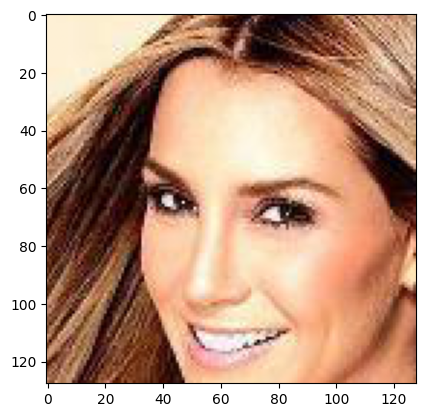

In [3]:
plt.imshow(train_data[0][0].permute(1, 2, 0))

In [4]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

print("device = ", device)

model = AE(256).to(device)

critrion = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

lr_sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")

device =  cuda


In [5]:
def train():
    model.train()
    loss_train = []
    count = 0
    for x in train_loader:
        x = x[0].to(device)
        optimizer.zero_grad()

        prediction, latent = model(x)
        loss = critrion(prediction, x)
        loss.backward()
        

        optimizer.step()
        
        if count % 50 == 0:
            loss_train.append(loss.item())
            print("current loss = ", loss.item())

            if count % 150 == 0:
                lr_sheduler.step(loss.item())

        count += 1


def val():
    pass

In [6]:
# train()
# model.eval()
# torch.save(model.state_dict(), "../weights/AE.pth")

model.load_state_dict(torch.load(".\weights\AE.pth"))

current loss =  0.6933574676513672
current loss =  0.5727478265762329
current loss =  0.5714699625968933
current loss =  0.5637472867965698
current loss =  0.5431811809539795
current loss =  0.5629023909568787
current loss =  0.5338284373283386
current loss =  0.5476636290550232
current loss =  0.5334153175354004
current loss =  0.5567108988761902
current loss =  0.5472205281257629
current loss =  0.5378364324569702
current loss =  0.5511773824691772
current loss =  0.5413070917129517
current loss =  0.5413739681243896
current loss =  0.5303264260292053
current loss =  0.5463902950286865
current loss =  0.5286247730255127
current loss =  0.5367215871810913
current loss =  0.5455285906791687
current loss =  0.5615229606628418
current loss =  0.530591607093811
current loss =  0.540947437286377
current loss =  0.5370752811431885
current loss =  0.5389537215232849
current loss =  0.5352327227592468
current loss =  0.5414464473724365
current loss =  0.5257589221000671
current loss =  0.5241

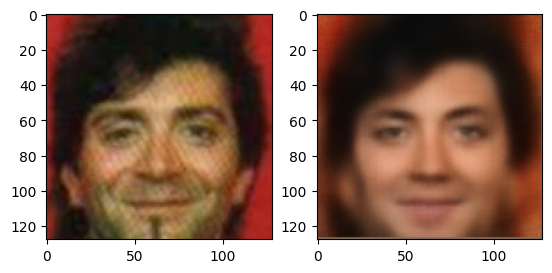

In [31]:
img = train_data[np.random.randint(0, 10000)][0]


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.permute(1, 2, 0))

reconstruct, _ = model(torch.unsqueeze(img, 0).to(device))
ax2.imshow(torch.squeeze(reconstruct.cpu().detach()).permute(1, 2, 0))

In [51]:
txt_file = open("C:\Visual_Studio\ML\data\celeba\list_attr_celeba.txt", "r")
csv_file = open("C:\Visual_Studio\ML\data\celeba\list_attr_celeba.csv", "w")

txt_file.readline() # reduce first line
csv_file.write("img_name," + txt_file.read().replace("  ", " ").replace(" ", ","))

txt_file.close()
csv_file.close()

In [58]:
df = pd.read_csv("C:\Visual_Studio\ML\data\celeba\list_attr_celeba.csv")
df = df.drop(columns="Unnamed: 41")
df

,img_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [60]:

list_smile = df.sort_values(by="Smiling", key=lambda x: x != 1)[["img_name", "Smiling"]][0:30]['img_name'].values
list_sad = df.sort_values(by="Smiling")[["img_name", "Smiling"]][0:30]['img_name'].values

list_smile

array(['000001.jpg', '081904.jpg', '159863.jpg', '081902.jpg',
       '081901.jpg', '081900.jpg', '081899.jpg', '159864.jpg',
       '081897.jpg', '159865.jpg', '081895.jpg', '159866.jpg',
       '159867.jpg', '159868.jpg', '159869.jpg', '081890.jpg',
       '159873.jpg', '081885.jpg', '081884.jpg', '159874.jpg',
       '081882.jpg', '081881.jpg', '159875.jpg', '159876.jpg',
       '081905.jpg', '159877.jpg', '081906.jpg', '159860.jpg',
       '081942.jpg', '081941.jpg'], dtype=object)

In [63]:
smile_vector = torch.zeros([1, 256])

tmp_smile = torch.zeros([1, 256])
model.eval()
for i in range(30):
    img = Image.open(f"C:\Visual_Studio\ML\data\celeba\img_align_celeba\{list_smile[i]}")
    img = data_transform(img)

    tmp_smile += model.cpu().encode(torch.unsqueeze(img, 0))

smile_vector / 30


tmp_sad = torch.zeros([1, 256])
for i in range(30):
    img = Image.open(f"C:\Visual_Studio\ML\data\celeba\img_align_celeba\{list_sad[i]}")
    img = data_transform(img)

    tmp_sad += model.cpu().encode(torch.unsqueeze(img, 0))

smile_vector = (tmp_smile / 30) - (tmp_sad / 30)

smile_vector

tensor([[ 1.2482e+00,  1.3504e+01,  7.2060e+00,  7.0291e-01, -6.1040e+00,
         -6.4269e+00,  1.8476e+00,  9.0406e-01, -2.7211e-01, -5.2865e+00,
         -9.8153e-01, -5.0837e+00,  3.3918e-02, -1.8136e+00, -4.8775e+00,
         -6.6260e+00, -2.0587e+00,  2.8135e+00, -6.5259e-02,  3.8202e+00,
         -1.2159e+00, -9.0193e-01, -2.3583e-01, -4.4249e-01, -1.4227e+00,
         -2.5639e+00, -3.1401e+00, -3.6707e-01,  5.5422e+00, -1.4749e+00,
         -1.0440e+00, -1.5255e-01, -5.4450e-01, -1.0959e+00, -1.9883e-01,
         -1.0812e+00, -3.5375e+00, -1.5003e+00,  3.4916e+00, -4.2584e+00,
         -5.9685e+00, -3.2109e-01, -6.5888e+00,  3.0004e-01, -7.6431e+00,
          1.9590e+00, -7.7506e-01, -1.2840e+00,  1.6814e+00, -1.2987e+00,
          2.1494e+00, -2.6855e+00, -1.7130e+00, -1.7994e+00, -3.5909e+00,
          2.6970e+00, -3.0318e+00, -2.0482e+00, -1.3196e-02,  6.0540e+00,
         -1.3969e+00, -2.0312e+00, -1.0319e+00, -1.9429e+00, -6.8636e+00,
         -1.6822e+00, -3.8818e+00, -6.

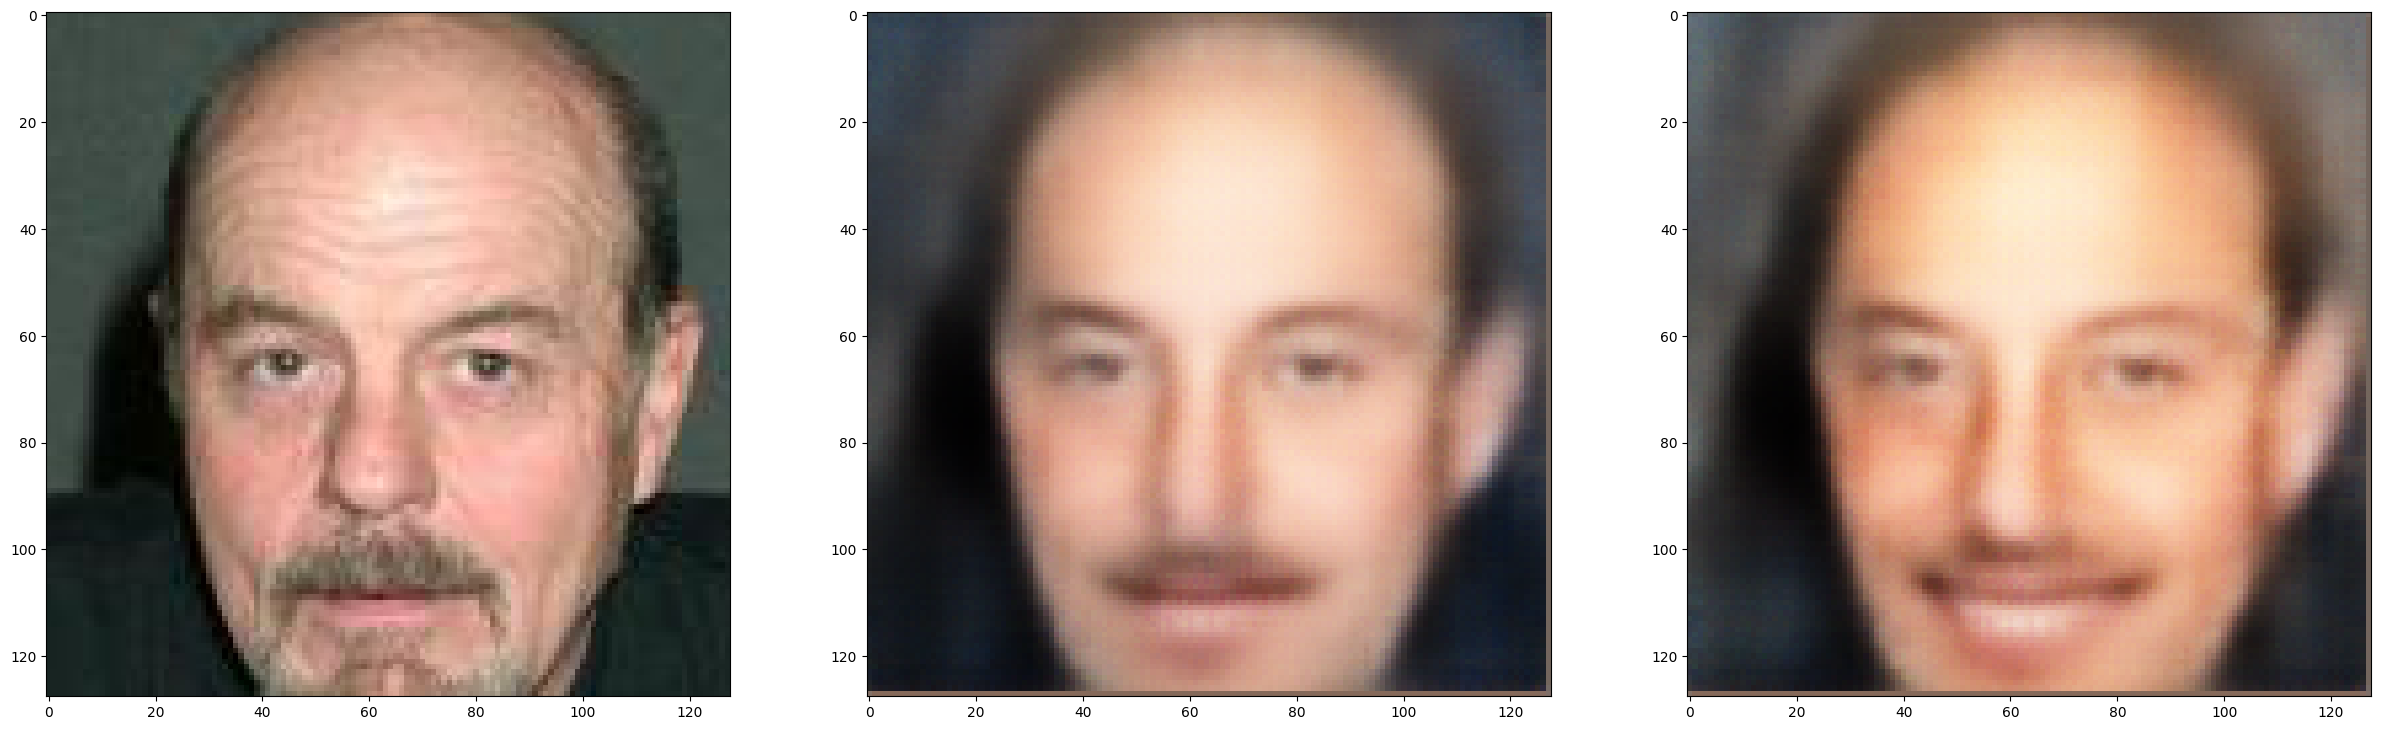

In [65]:
test = train_data[np.random.randint(0, 10000)][0]
# test = img

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(test.permute(1, 2, 0))

_, latent = model(torch.unsqueeze(test, 0))
ax2.imshow(torch.squeeze(_.cpu().detach()).permute(1, 2, 0))

pred = model.decode(latent + smile_vector * 1)
ax3.imshow(torch.squeeze(pred.cpu().detach()).permute(1, 2, 0))